# Performance
In a laboratory setting, we compared the low-cost UBC AQ sensors to a [GRIMM](https://www.grimm-aerosol.com/products-en/dust-monitors/the-dust-decoder/11-d/) OPC sensor (Model: 1.109).  We produced air-borne salt particles as a measurand by feeding salt solutions with known molar concentrations into an atomizer. After the atomizer made the air-borne salt particles, they traveled through an adjustable filter (enabling concentrations control) and into a 22L glass chamber containing the UBC AQ sensors (Fig 1). The Grimm OPC sensor pulled air from the glass chamber to sample the salt concentrations simultaneously. There was an exhaust port to maintain persistent salt concentration levels and a small fan within the glass chamber to mix the air. 
<br>
<br>
<img src="_static/img/chamber.jpeg" alt="chamber" width="300"/>
<br>
<br>

Lets dive in.

In [1]:
import context
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.pylab as pylab

from datetime import datetime, timedelta
from pathlib import Path
from context import data_dir, save_dir

# Back pratices but this keeps the notebook clean when displaying on html
import warnings
warnings.filterwarnings("ignore")

******************************
context imported. Front of path:
/Users/rodell/Documents/Arduino/docs
/Users/rodell/Documents/Arduino/docs/source
******************************

through /Users/rodell/Documents/Arduino/docs/source/context.py -- pha



## Import OPC data!
UBC AQ data was one minute averaged to match the GRIMM sample rate.

In [2]:

## define date of interest
date_of_int = '20210430' # options 20210430 or 20210502


def prepare_df(ubc_pm):
  """
  Function cleans UBC OPCs data by removing duplicate headers and dropping error values. 
  Once cleaned takes 1 min avg of data to match GRIM sample rate.
  """
  df = pd.read_csv(str(data_dir) + ubc_pm + date_of_int + '.TXT')
  df = df.drop(df[df.rtctime == 'rtctime'].index)
  df = df[~df['pm10_env'].str.contains('Rec')]
  time = pd.to_datetime(df['rtctime'])
  df.index = pd.DatetimeIndex(pd.to_datetime(df['rtctime']))
  df = df.drop(['rtctime'], axis=1)
  df = df.astype(float)
  df = df[df['pm10_env'] < 4000]
  df = df[df['pm25_env'] < 4000]
  df = df[df['pm100_env'] < 4000]

  df = df.resample('1Min').mean()

  col = ubc_pm.strip('/').replace('-','_')
  new_name = {}
  for name in list(df):
    new_name.update({name : col+'_'+name} )
  df = df.rename(new_name, axis='columns')

  return df



Open the ubc opcs

In [3]:

df_pm01 = prepare_df("/UBC-PM-01/")
df_pm02 = prepare_df("/UBC-PM-02/")
df_pm03 = prepare_df("/UBC-PM-03/")
df_pm04 = prepare_df("/UBC-PM-04/")
df_pm05 = prepare_df("/UBC-PM-05/")

df_ubc = reduce(lambda x, y: pd.merge(x, y, on='rtctime'), [df_pm01, df_pm02, df_pm03, df_pm04, df_pm05])
df_ubc.columns = df_ubc.columns.str.replace('_y', '')



Open the grim opc

In [4]:
try:
  df_grim = pd.read_csv(str(data_dir) + f'/GRIM/{date_of_int}.csv')
  df_grim['date & time'] = pd.to_datetime(df_grim['date & time'])
except:
  pathlist = sorted(Path(str(data_dir) + '/2021_OPCintercomparison/').glob(f'{date_of_int}*'))
  sheets = ['PM values', 'Count values', 'Mass values', 'Log values']
  df_grim = [pd.read_excel(f'{pathlist[0]}/{pathlist[0].stem}_sample01.xlsx', sheet_name= sheet, skiprows=4, engine='openpyxl') for sheet in sheets]
  df_grim = reduce(lambda x, y: pd.merge(x, y, on='date & time'), df_grim)
  df_grim['date & time'] = pd.to_datetime(df_grim['date & time'], dayfirst=True)
  df_grim.to_csv(str(data_dir) + f'/GRIM/{date_of_int}.csv', index=False)


df_grim['date & time'] = df_grim['date & time'].dt.round('1min')  
df_grim = df_grim.set_index('date & time')
df_grim = df_grim.join(df_pm03, how='outer')
df_grim = df_grim.dropna()

df_final = pd.merge(left=df_grim, right=df_ubc, left_index=True, right_index=True, how='left')
df_final.columns = df_final.columns.str.replace('_y', '')

Define default font sizes for ploting

In [5]:
params = {
         'xtick.labelsize':14,
         'ytick.labelsize': 14,
          'axes.labelsize':14,

         }

pylab.rcParams.update(params)

### Plot PM 1.0 

Text(0.5, 0, '$\\frac{\\mu g}{m^3}$')

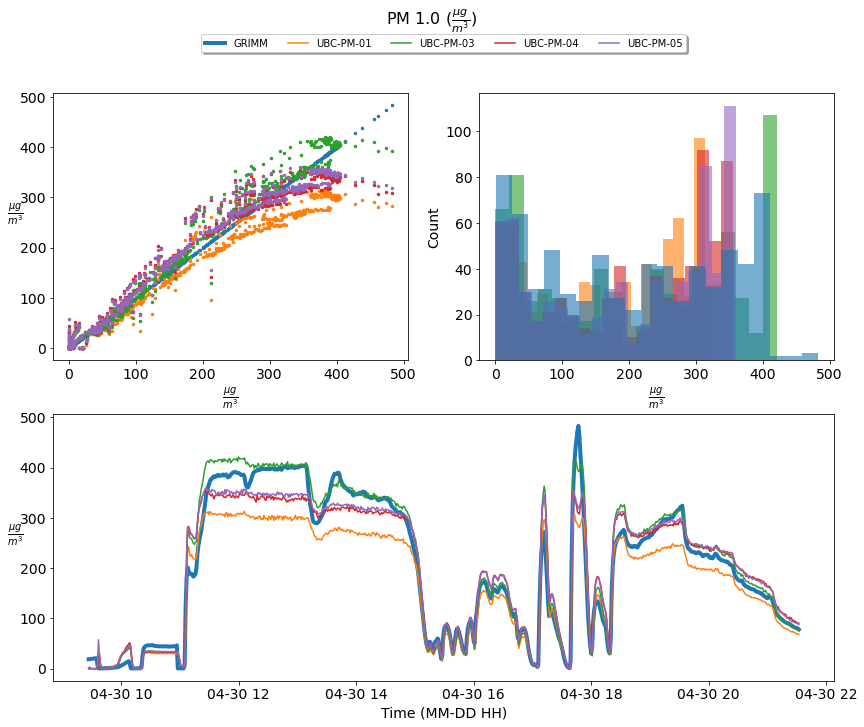

In [6]:

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


fig = plt.figure(figsize=(14, 12))
fig.autofmt_xdate()
xfmt = DateFormatter("%m-%d %H:00")
fig.suptitle(r"PM 1.0 ($\frac{\mu g}{m^3}$)", fontsize=16)
ax = fig.add_subplot(2, 1, 2)
ax.plot(df_final.index,df_final['PM1 [ug/m3]'], lw = 4.0, label = 'GRIMM', color = colors[0])
ax.plot(df_final.index,df_final['UBC_PM_01_pm10_env'], label = 'UBC-PM-01', color = colors[1])
# ax.plot(df_final.index,df_final['UBC_PM_02_pm10_env'], label = 'UBC-PM-02', color = colors[2])
ax.plot(df_final.index,df_final['UBC_PM_03_pm10_env'], label = 'UBC-PM-03', color = colors[2])
ax.plot(df_final.index,df_final['UBC_PM_04_pm10_env'], label = 'UBC-PM-04', color = colors[3])
ax.plot(df_final.index,df_final['UBC_PM_05_pm10_env'], label = 'UBC-PM-05', color = colors[4])
ax.set_ylabel(r'$\frac{\mu g}{m^3}$', rotation=0)
ax.set_xlabel('Time (MM-DD HH)')
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 2.44),
    ncol=6,
    fancybox=True,
    shadow=True,
)
ax = fig.add_subplot(2, 2, 1)
size = 6
ax.scatter(df_final['PM1 [ug/m3]'], df_final['PM1 [ug/m3]'], s=size, color = colors[0])
ax.scatter(df_final['PM1 [ug/m3]'], df_final['UBC_PM_01_pm10_env'], s=size, color = colors[1])
# ax.scatter(df_grim['PM1 [ug/m3]'], df_final['UBC_PM_02_pm10_env'], s=size, color = colors[2])
ax.scatter(df_final['PM1 [ug/m3]'], df_final['UBC_PM_03_pm10_env'], s=size, color = colors[2])
ax.scatter(df_final['PM1 [ug/m3]'], df_final['UBC_PM_04_pm10_env'], s=size, color = colors[3])
ax.scatter(df_final['PM1 [ug/m3]'], df_final['UBC_PM_05_pm10_env'], s=size, color = colors[4])
ax.set_ylabel(r'$\frac{\mu g}{m^3}$', rotation=0)
ax.set_xlabel(r'$\frac{\mu g}{m^3}$')

ax = fig.add_subplot(2, 2, 2)
bins = 20
alpha = 0.6
ax.hist(df_final['PM1 [ug/m3]'],bins,alpha = alpha, color = colors[0], zorder = 10)
ax.hist(df_final['UBC_PM_01_pm10_env'],bins, alpha = alpha, color = colors[1])
# ax.hist(df_final['UBC_PM_02_pm10_env'],bins, alpha = alpha,color = colors[2])
ax.hist(df_final['UBC_PM_03_pm10_env'],bins, alpha = alpha, color = colors[2])
ax.hist(df_final['UBC_PM_04_pm10_env'],bins, alpha = alpha,color = colors[3])
ax.hist(df_final['UBC_PM_05_pm10_env'],bins, alpha = alpha, color = colors[4])
ax.set_ylabel('Count')
ax.set_xlabel(r'$\frac{\mu g}{m^3}$')

Figure shows time series comparison of the measured PM 1.0 contractions of four UBC AQ Sensors [UBC-PM-01 (orange), UBC-PM-03 (green), UBC-PM-04 (red), UBC-PM-05 (blue)] and the GRIM sensor [GRIMM (blue)]. The time series shows one minute averaged PM 1.0 contractions incremented from 2021-04-30 09:27:00 unitl 2021-04-30 21:36:00. 

### Plot PM 2.5 

Text(0.5, 0, '$\\frac{\\mu g}{m^3}$')

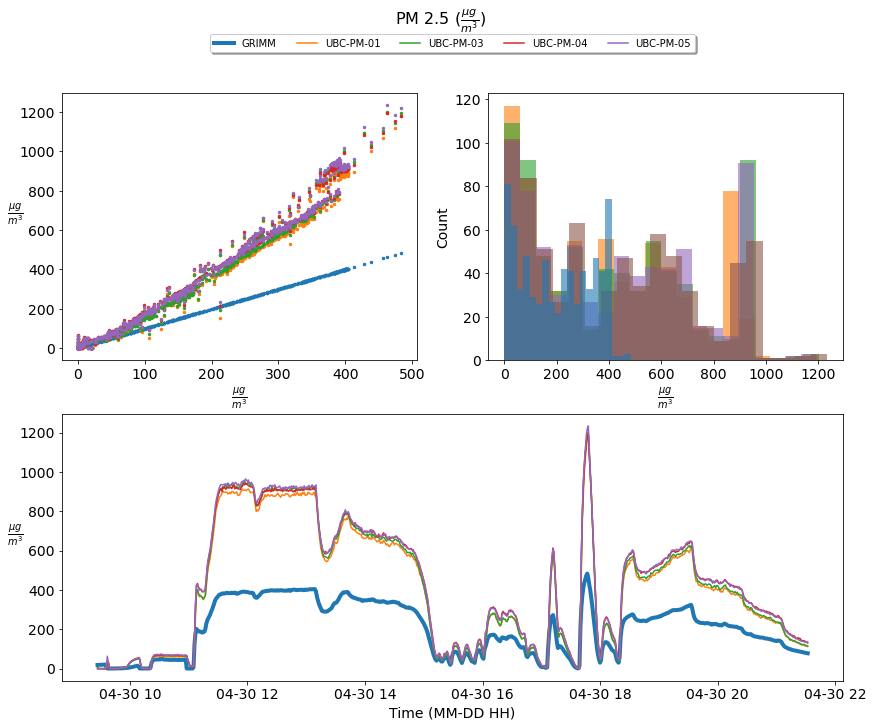

In [7]:


fig = plt.figure(figsize=(14, 12))
fig.autofmt_xdate()
xfmt = DateFormatter("%m-%d %H:00")
fig.suptitle(r"PM 2.5 ($\frac{\mu g}{m^3}$)", fontsize=16)
ax = fig.add_subplot(2, 1, 2)
ax.plot(df_final.index,df_final['PM2.5 [ug/m3]'], lw = 4.0, label = 'GRIMM', color = colors[0])
ax.plot(df_final.index,df_final['UBC_PM_01_pm25_env'], label = 'UBC-PM-01', color = colors[1])
# ax.plot(df_final.index,df_final['UBC_PM_02_pm10_env'], label = 'UBC-PM-02', color = colors[2])
ax.plot(df_final.index,df_final['UBC_PM_03_pm25_env'], label = 'UBC-PM-03', color = colors[2])
ax.plot(df_final.index,df_final['UBC_PM_04_pm25_env'], label = 'UBC-PM-04', color = colors[3])
ax.plot(df_final.index,df_final['UBC_PM_05_pm25_env'], label = 'UBC-PM-05', color = colors[4])
ax.set_ylabel(r'$\frac{\mu g}{m^3}$', rotation=0)
ax.set_xlabel('Time (MM-DD HH)')
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 2.44),
    ncol=6,
    fancybox=True,
    shadow=True,
)
ax = fig.add_subplot(2, 2, 1)
size = 6
ax.scatter(df_final['PM2.5 [ug/m3]'], df_final['PM2.5 [ug/m3]'], s=size, color = colors[0])
ax.scatter(df_final['PM2.5 [ug/m3]'], df_final['UBC_PM_01_pm25_env'], s=size, color = colors[1])
# ax.scatter(df_grim['PM2.5 [ug/m3]'], df_final['UBC_PM_02_pm25_env'], s=size, color = colors[2])
ax.scatter(df_final['PM2.5 [ug/m3]'], df_final['UBC_PM_03_pm25_env'], s=size, color = colors[2])
ax.scatter(df_final['PM2.5 [ug/m3]'], df_final['UBC_PM_04_pm25_env'], s=size, color = colors[3])
ax.scatter(df_final['PM2.5 [ug/m3]'], df_final['UBC_PM_05_pm25_env'], s=size, color = colors[4])
ax.set_ylabel(r'$\frac{\mu g}{m^3}$', rotation=0)
ax.set_xlabel(r'$\frac{\mu g}{m^3}$')

ax = fig.add_subplot(2, 2, 2)
bins = 20
alpha = 0.6
ax.hist(df_final['PM2.5 [ug/m3]'],bins,alpha = alpha, color = colors[0], zorder = 10)
ax.hist(df_final['UBC_PM_01_pm25_env'],bins, alpha = alpha, color = colors[1])
# ax.hist(df_final['UBC_PM_02_pm25_env'],bins, alpha = alpha,color = colors[2])
ax.hist(df_final['UBC_PM_03_pm25_env'],bins, alpha = alpha, color = colors[2])
ax.hist(df_final['UBC_PM_04_pm25_env'],bins, alpha = alpha,color = colors[4])
ax.hist(df_final['UBC_PM_05_pm25_env'],bins, alpha = alpha, color = colors[5])
ax.set_ylabel('Count')
ax.set_xlabel(r'$\frac{\mu g}{m^3}$')

Figure shows time series comparison of the measured PM 2.5 contractions of four UBC AQ Sensors [UBC-PM-01 (orange), UBC-PM-03 (green), UBC-PM-04 (red), UBC-PM-05 (blue)] and the GRIM sensor [GRIMM (blue)]. The time series shows one minute averaged PM 1.0 contractions incremented from 2021-04-30 09:27:00 unitl 2021-04-30 21:36:00. 

### Plot PM 10 

Text(0.5, 0, '$\\frac{\\mu g}{m^3}$')

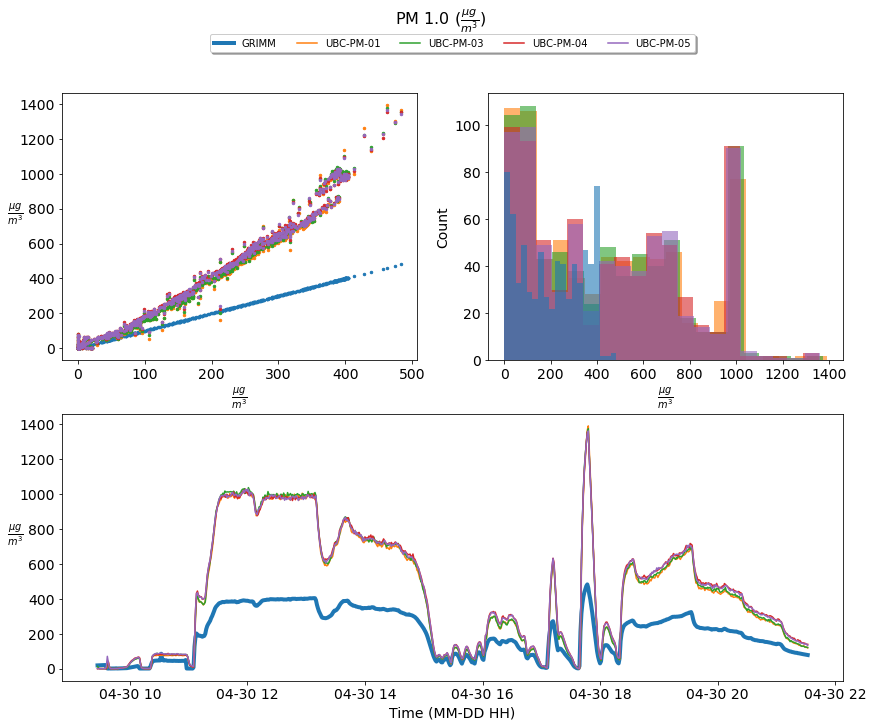

In [8]:

fig = plt.figure(figsize=(14, 12))
fig.autofmt_xdate()
xfmt = DateFormatter("%m-%d %H:00")
fig.suptitle(r"PM 1.0 ($\frac{\mu g}{m^3}$)", fontsize=16)
ax = fig.add_subplot(2, 1, 2)
ax.plot(df_final.index,df_final['PM10 [ug/m3]'], lw = 4.0, label = 'GRIMM', color = colors[0])
ax.plot(df_final.index,df_final['UBC_PM_01_pm100_env'], label = 'UBC-PM-01', color = colors[1])
# ax.plot(df_final.index,df_final['UBC_PM_02_pm100_env'], label = 'UBC-PM-02', color = colors[2])
ax.plot(df_final.index,df_final['UBC_PM_03_pm100_env'], label = 'UBC-PM-03', color = colors[2])
ax.plot(df_final.index,df_final['UBC_PM_04_pm100_env'], label = 'UBC-PM-04', color = colors[3])
ax.plot(df_final.index,df_final['UBC_PM_05_pm100_env'], label = 'UBC-PM-05', color = colors[4])
ax.set_ylabel(r'$\frac{\mu g}{m^3}$', rotation=0)
ax.set_xlabel('Time (MM-DD HH)')
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 2.44),
    ncol=6,
    fancybox=True,
    shadow=True,
)
ax = fig.add_subplot(2, 2, 1)
size = 6
ax.scatter(df_final['PM10 [ug/m3]'], df_final['PM10 [ug/m3]'], s=size, color = colors[0])
ax.scatter(df_final['PM10 [ug/m3]'], df_final['UBC_PM_01_pm100_env'], s=size, color = colors[1])
# ax.scatter(df_grim['PM10 [ug/m3]'], df_final['UBC_PM_02_pm100_env'], s=size, color = colors[2])
ax.scatter(df_final['PM10 [ug/m3]'], df_final['UBC_PM_03_pm100_env'], s=size, color = colors[2])
ax.scatter(df_final['PM10 [ug/m3]'], df_final['UBC_PM_04_pm100_env'], s=size, color = colors[3])
ax.scatter(df_final['PM10 [ug/m3]'], df_final['UBC_PM_05_pm100_env'], s=size, color = colors[4])
ax.set_ylabel(r'$\frac{\mu g}{m^3}$', rotation=0)
ax.set_xlabel(r'$\frac{\mu g}{m^3}$')

ax = fig.add_subplot(2, 2, 2)
bins = 20
alpha = 0.6
ax.hist(df_final['PM10 [ug/m3]'],bins,alpha = alpha, color = colors[0], zorder = 10)
ax.hist(df_final['UBC_PM_01_pm100_env'],bins, alpha = alpha, color = colors[1])
# ax.hist(df_final['UBC_PM_02_pm10_env'],bins, alpha = alpha,color = colors[2])
ax.hist(df_final['UBC_PM_03_pm100_env'],bins, alpha = alpha, color = colors[2])
ax.hist(df_final['UBC_PM_04_pm100_env'],bins, alpha = alpha,color = colors[3])
ax.hist(df_final['UBC_PM_05_pm100_env'],bins, alpha = alpha, color = colors[4])
ax.set_ylabel('Count')
ax.set_xlabel(r'$\frac{\mu g}{m^3}$')

Figure shows time series comparison of the measured PM 10 contractions of four UBC AQ Sensors [UBC-PM-01 (orange), UBC-PM-03 (green), UBC-PM-04 (red), UBC-PM-05 (blue)] and the GRIM sensor [GRIMM (blue)]. The time series shows one minute averaged PM 1.0 contractions incremented from 2021-04-30 09:27:00 unitl 2021-04-30 21:36:00. 

## Preliminary Results
We see the UBC-AQ sensors are performing marginally well at PM 1.0 concentrations. However,  the UBC-AQ sensors are grossly over-predicting the concentration levels of PM 2.5 and 10. Let's figure out why this is happening. 

### Plot counts of particle sizes through time.

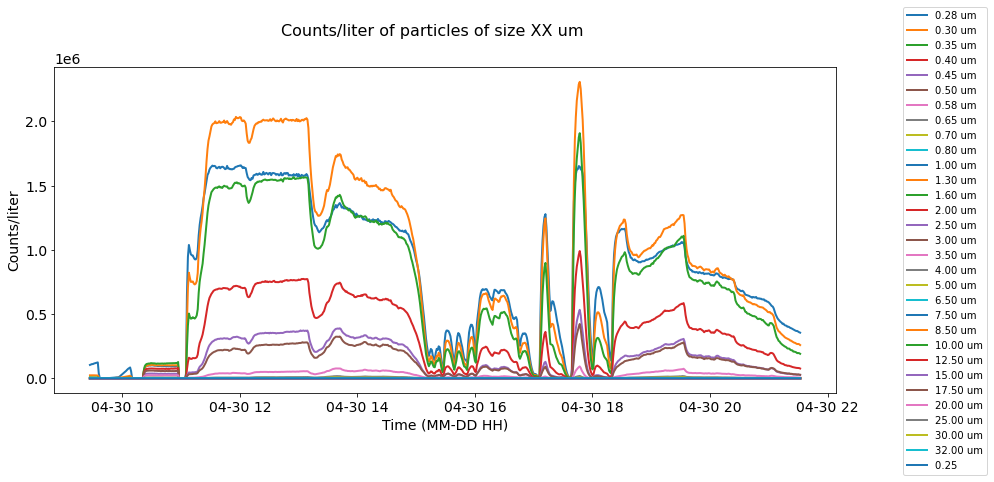

In [9]:
fig = plt.figure(figsize=(14, 6))
fig.suptitle("Counts/liter of particles of size XX um", fontsize=16)
ax = fig.add_subplot(1, 1, 1)
var_list = list(df_final)[7:38]
# var_list = list(df_grim)[7:16]
for var in var_list:
  ax.plot(df_final.index,df_final[var], lw = 2.0, label = var[:-2])
ax.set_ylabel('Counts/liter')
ax.set_xlabel('Time (MM-DD HH)')
ax.legend(
  bbox_to_anchor=(1.2, 1.2),
)

The figure shows the counts/liter of particles of size XX um. 

### Plot counts of particle sizes averaged over time.

[Text(0, 0, '0.28 um'),
 Text(1, 0, '0.30 um'),
 Text(2, 0, '0.35 um'),
 Text(3, 0, '0.40 um'),
 Text(4, 0, '0.45 um'),
 Text(5, 0, '0.50 um'),
 Text(6, 0, '0.58 um'),
 Text(7, 0, '0.65 um'),
 Text(8, 0, '0.70 um'),
 Text(9, 0, '0.80 um'),
 Text(10, 0, '1.00 um'),
 Text(11, 0, '1.30 um'),
 Text(12, 0, '1.60 um'),
 Text(13, 0, '2.00 um'),
 Text(14, 0, '2.50 um'),
 Text(15, 0, '3.00 um'),
 Text(16, 0, '3.50 um'),
 Text(17, 0, '4.00 um'),
 Text(18, 0, '5.00 um'),
 Text(19, 0, '6.50 um'),
 Text(20, 0, '7.50 um'),
 Text(21, 0, '8.50 um'),
 Text(22, 0, '10.00 um'),
 Text(23, 0, '12.50 um'),
 Text(24, 0, '15.00 um'),
 Text(25, 0, '17.50 um'),
 Text(26, 0, '20.00 um'),
 Text(27, 0, '25.00 um'),
 Text(28, 0, '30.00 um'),
 Text(29, 0, '32.00 um'),
 Text(30, 0, '0.25 ')]

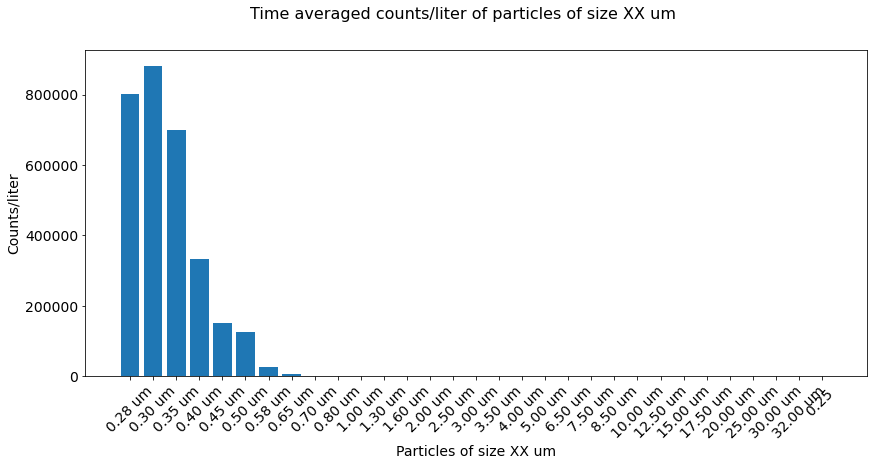

In [10]:
fig = plt.figure(figsize=(14, 6))
fig.suptitle("Time averaged counts/liter of particles of size XX um", fontsize=16)
ax = fig.add_subplot(1, 1, 1)
var_list = list(df_final)[7:38]
var_labels = [var[:-2] for var in var_list]
df_final_mean = df_final[var_list].mean()

ax.bar(var_labels,df_final_mean)
ax.set_ylabel('Counts/liter')
ax.set_xlabel('Particles of size XX um')
ax.set_xticklabels(var_labels, rotation = 45)

The figure shows time averaged counts/liter of particles of size XX um. 